In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from render_galaxy import *
from matplotlib.patches import Ellipse
import cProfile

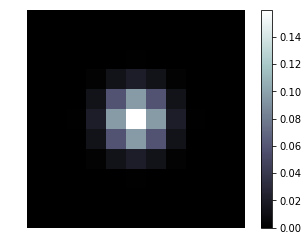

In [3]:
psf_size = 11
psf_sigma = 2

psf_x = np.linspace(-10, 10, psf_size)
psf_y = np.linspace(-10, 10, psf_size)

psf_x, psf_y = np.meshgrid(psf_x, psf_y)

psf = (1/(2*np.pi*psf_sigma**2) * np.exp(-(psf_x**2/(2*psf_sigma**2)
     + psf_y**2/(2*psf_sigma**2))))
psf /= np.sum(psf)

plt.imshow(psf, cmap='bone')
plt.axis('off')
plt.colorbar()
None

In [4]:
disk_comp = {
    'mu': np.zeros(2) + 256,
    'roll': np.pi / 3,
    'rEff': 250,
    'axRatio': 0.5,
    'c': 2,
    'i0': 1,
    'n': 1
}
bulge_comp = {
    'mu': np.zeros(2) + 256,
    'roll': 0,
    'rEff': 40,
    'axRatio': 1,
    'c': 2,
    'i0': 1,
    'n': 1
}

In [5]:
image_size = 512
oversample_n = 5

0.2444140911102295


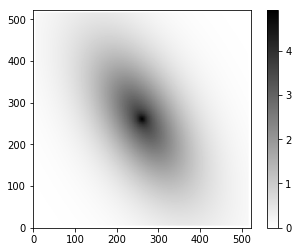

In [6]:
import time
t0 = time.time()
disk_arr = sersic_comp(disk_comp)
bulge_arr = sersic_comp(bulge_comp)

post_processed_image = asinh_stretch(
    convolve2d(disk_arr + bulge_arr, psf)
)
print(time.time() - t0)
plt.imshow(post_processed_image, cmap='gray_r', origin='lower')
plt.colorbar()

Ellipse(xy=(256.0, 256.0), width=250, height=125.0, angle=-59.99999999999999)


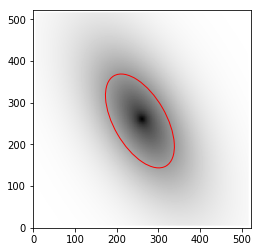

In [7]:
disk_isophote = Ellipse(
    disk_comp['mu'],
    disk_comp['rEff'],
    disk_comp['rEff'] * disk_comp['axRatio'],
    -np.rad2deg(disk_comp['roll']),
    facecolor='none',
    edgecolor='r'
)
plt.imshow(post_processed_image, cmap='gray_r', origin='lower')
plt.gca().add_artist(disk_isophote)
print(disk_isophote)

In [8]:
arm_points = np.stack((np.arange(100, 250)+30, np.arange(100, 250)+30)).T

In [9]:
spiral_params = {
    'i0': 1, 'spread': 10, 'falloff': 1,
}
spiral_arr = spiral_arm(arm_points, spiral_params, disk_comp)

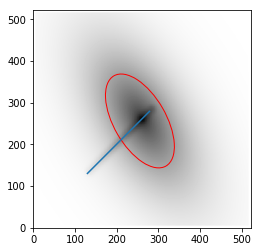

In [10]:
post_processed_image = asinh_stretch(
    convolve2d(disk_arr + bulge_arr + spiral_arr, psf)
)
plt.imshow(post_processed_image, cmap='gray_r', origin='lower')

disk_isophote = Ellipse(
    disk_comp['mu'],
    disk_comp['rEff'],
    disk_comp['rEff'] * disk_comp['axRatio'],
    -np.rad2deg(disk_comp['roll']),
    facecolor='none',
    edgecolor='r'
)
plt.gca().add_artist(disk_isophote)
plt.plot(*arm_points.T)

In [11]:
import json
with open('gb-classifications-9_11_18.json') as f:
    annotations = json.load(f)

In [12]:
a = annotations[6720]
a

[{'task': 'disk',
  'value': [{'task': 'drawDisk',
    'value': [{'x': 236.94473266601562,
      'y': 250.8167724609375,
      'rx': 13.129583854364375,
      'ry': 6.5647919271821875,
      'tool': 0,
      'angle': 38.15612705140277,
      'frame': 0}]},
   {'task': 'scaleSlider', 'value': '1'},
   {'task': 'T13', 'value': '0.2'}]},
 {'task': 'bulge',
  'value': [{'task': 'drawBulge', 'value': []},
   {'task': 'scaleSlider', 'value': '1'},
   {'task': 'intensitySlider', 'value': '0.5'},
   {'task': 'sersicSlider', 'value': '1'}]},
 {'task': 'bar',
  'value': [{'task': 'drawBar', 'value': []},
   {'task': 'scaleSlider', 'value': '1'},
   {'task': 'T16', 'value': 1},
   {'task': 'T15', 'value': '0.5'},
   {'task': 'shapeSlider', 'value': '2'}]},
 {'task': 'spiral',
  'value': [{'task': 'drawSpiral', 'value': []},
   {'task': 'falloffSlider', 'value': '1'}]}]

In [13]:
import parse_annotation as pa

parsed_annotation = pa.parse_annotation(a)
parsed_annotation

TypeError: can't multiply sequence by non-int of type 'float'

In [14]:
print('Rendering...')
print('\tDisk')
disk_arr = sersic_comp(parsed_annotation['disk'])
print('\tBulge')
bulge_arr = sersic_comp(parsed_annotation['bulge'])
print('\tBar')
bar_arr = sersic_comp(parsed_annotation['bar'])
print('\tSpiral arms')
spiral_arr = np.zeros(disk_arr.shape)
for arm_points, spiral_params in parsed_annotation['spiral']:
    spiral_arr += spiral_arm(arm_points, spiral_params, parsed_annotation['disk'])
print('Post-processing')
post_processed_image = asinh_stretch(
    convolve2d(disk_arr + bulge_arr + bar_arr + spiral_arr, psf)
)

Rendering...
	Disk


NameError: name 'parsed_annotation' is not defined

NameError: name 'parsed_annotation' is not defined

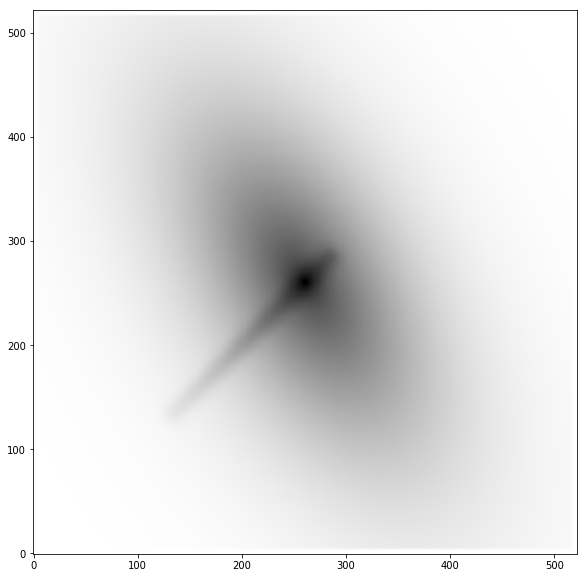

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(post_processed_image, cmap='gray_r', origin='lower')
disk_isophote = Ellipse(
    parsed_annotation['disk']['mu'],
    parsed_annotation['disk']['rEff'],
    parsed_annotation['disk']['rEff'] * parsed_annotation['disk']['axRatio'],
    -np.rad2deg(parsed_annotation['disk']['roll']),
    facecolor='none',
    edgecolor='r'
)
bulge_isophote = Ellipse(
    parsed_annotation['bulge']['mu'],
    parsed_annotation['bulge']['rEff'],
    parsed_annotation['bulge']['rEff'] * parsed_annotation['bulge']['axRatio'],
    -np.rad2deg(parsed_annotation['bulge']['roll']),
    facecolor='none',
    edgecolor='C0'
)
plt.gca().add_artist(disk_isophote)
plt.gca().add_artist(bulge_isophote)
plt.colorbar()